# simple 6D PS reconstruction

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data_2screens
from phase_space_reconstruction.utils import split_2screen_dset
from phase_space_reconstruction.train import train_3d_scan_2screens

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from stats import plot_projections_with_contours

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
yaml_dir = os.path.join('data', 'yaml_files')
save_dir =  os.path.join('data', 'two_screens')
p0c = 43.36e6 # reference momentum in eV/c
gt = create_beam(
    base_yaml = os.path.join(yaml_dir, 'base.yaml'),
    transforms_yaml = os.path.join(yaml_dir, 'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
)

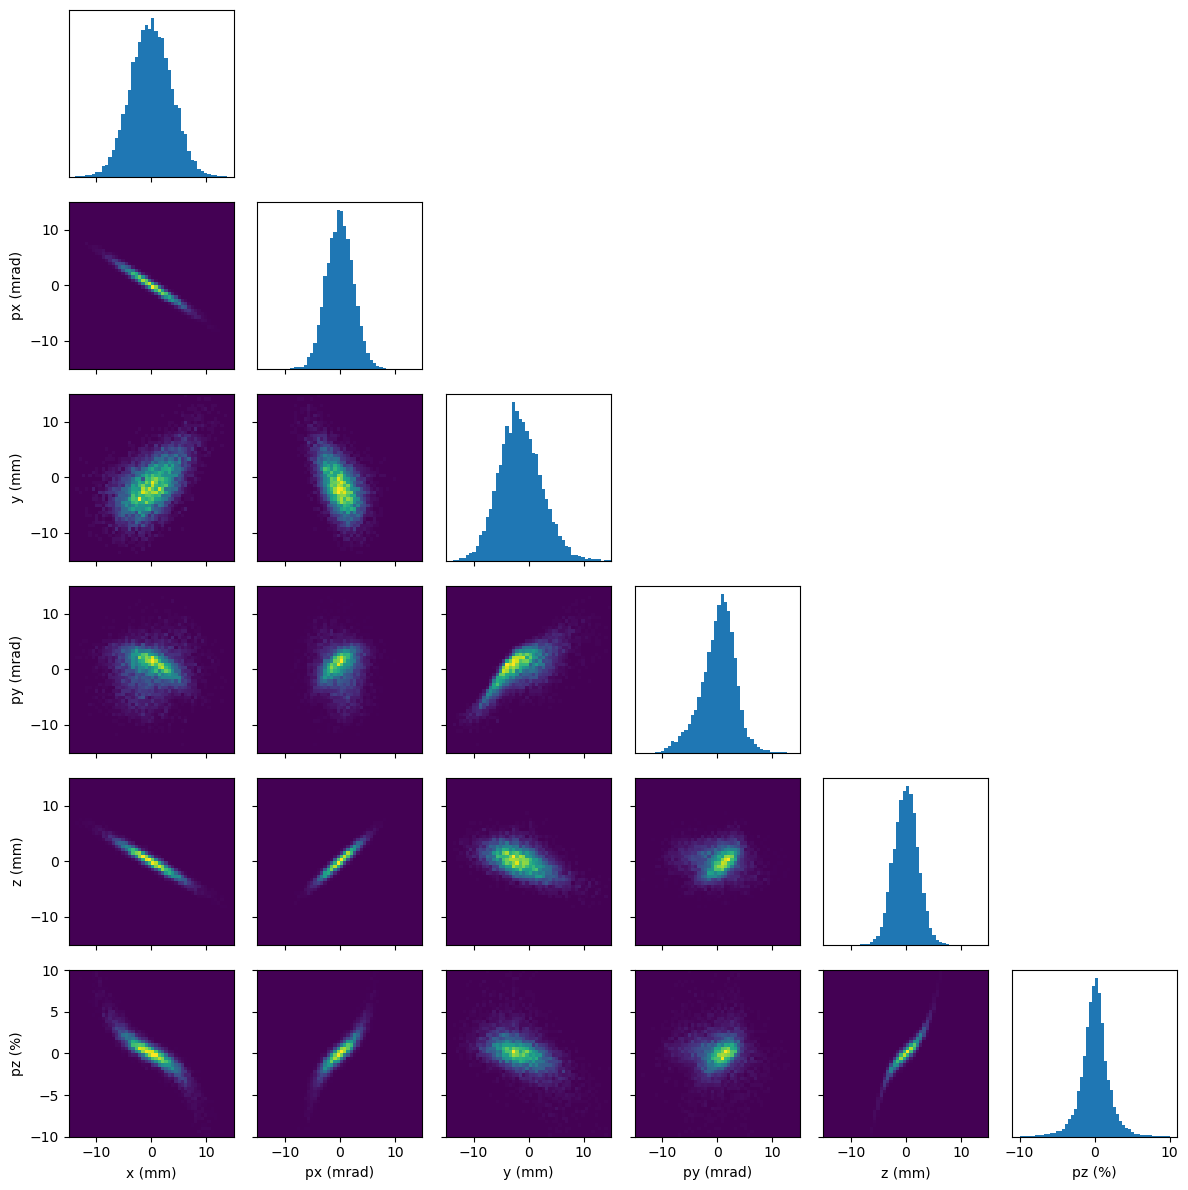

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-10e-2, 10e-2]]) 
fig, ax = plot_projections(
    gt.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 = 7.570125
k2 = -15.704693
k3 = 1.0

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 10
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)

screen0 = create_screen(100*1e-3, 200)
screen1 = create_screen(200*1e-3, 200)

## 3D scan training data

In [6]:
# generate and save train and test datasets
dset = run_3d_scan_2screens(
    gt, 
    lattice,
    screen0,
    screen1, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, '3d_scan_train.dset'),
    n_imgs_per_param = 4,
)
print(dset.params.shape)
print(dset.images.shape)

dataset0 saved as 'data/two_screens/3d_scan_train.dset'
torch.Size([10, 2, 2, 3])
torch.Size([10, 2, 2, 4, 200, 200])


In [11]:
train_dset, test_dset = split_2screen_dset(dset)

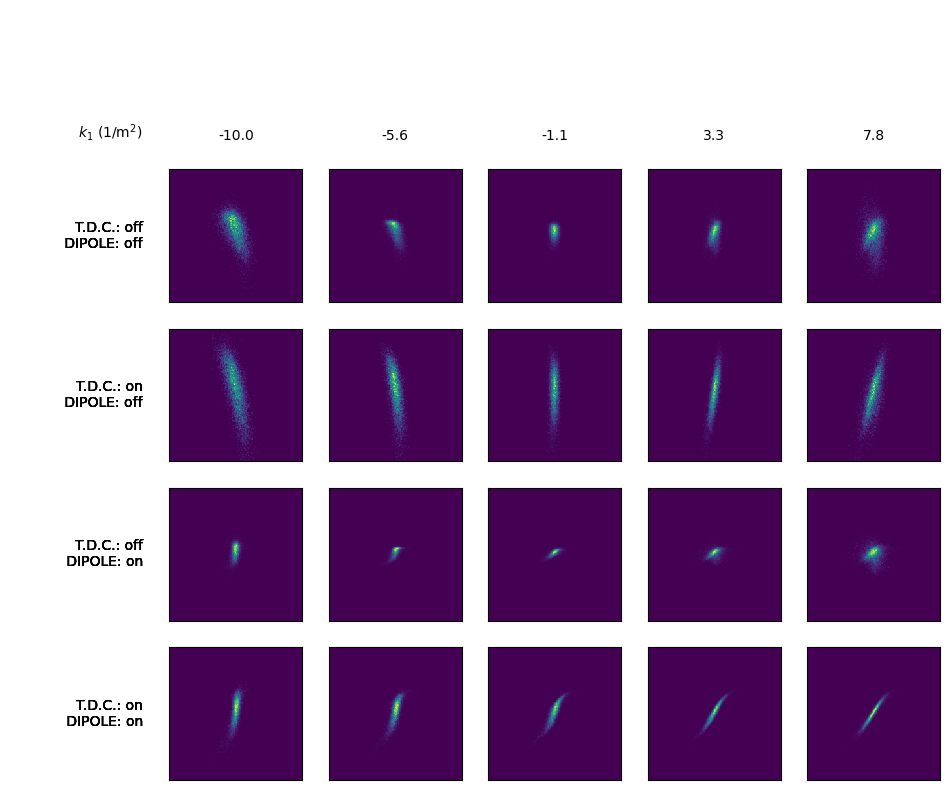

In [13]:
plot_3d_scan_data_2screens(train_dset)
plt.show()

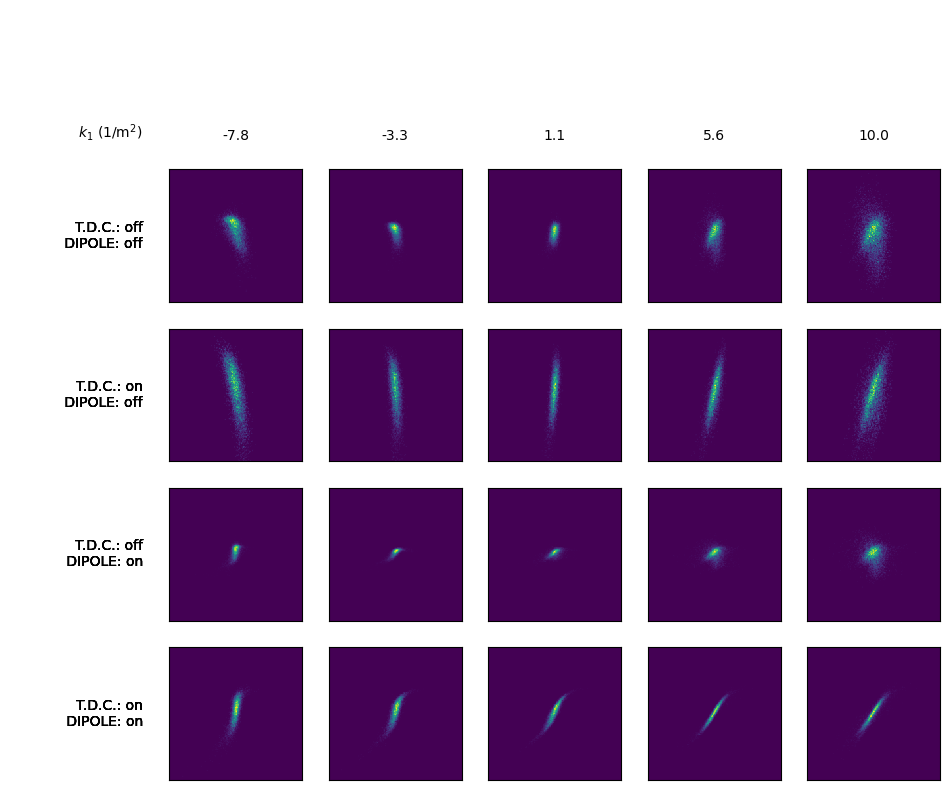

In [14]:
plot_3d_scan_data_2screens(test_dset)
plt.show()

### 10,000 particles

In [15]:
%%time

# training
pred_beam = train_3d_scan_2screens(
    train_dset, 
    lattice, 
    p0c, 
    screen0,
    screen1,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 10_000, 
    device = 'cuda'
    )
pred_beam = pred_beam.numpy_particles()
torch.cuda.empty_cache()

Using device: cuda


/home/jp/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4185538.7500, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(773480.6250, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(666254.8750, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(663177.5000, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(640858.4375, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(617998.3750, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(626522.0625, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(613679.3750, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(612432.0625, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(619448.7500, device='cuda:0', grad_fn=<MulBackward0>)
CPU times: user 1min 30s, sys: 4.74 s, total: 1min 34s
Wall time: 1min 35s


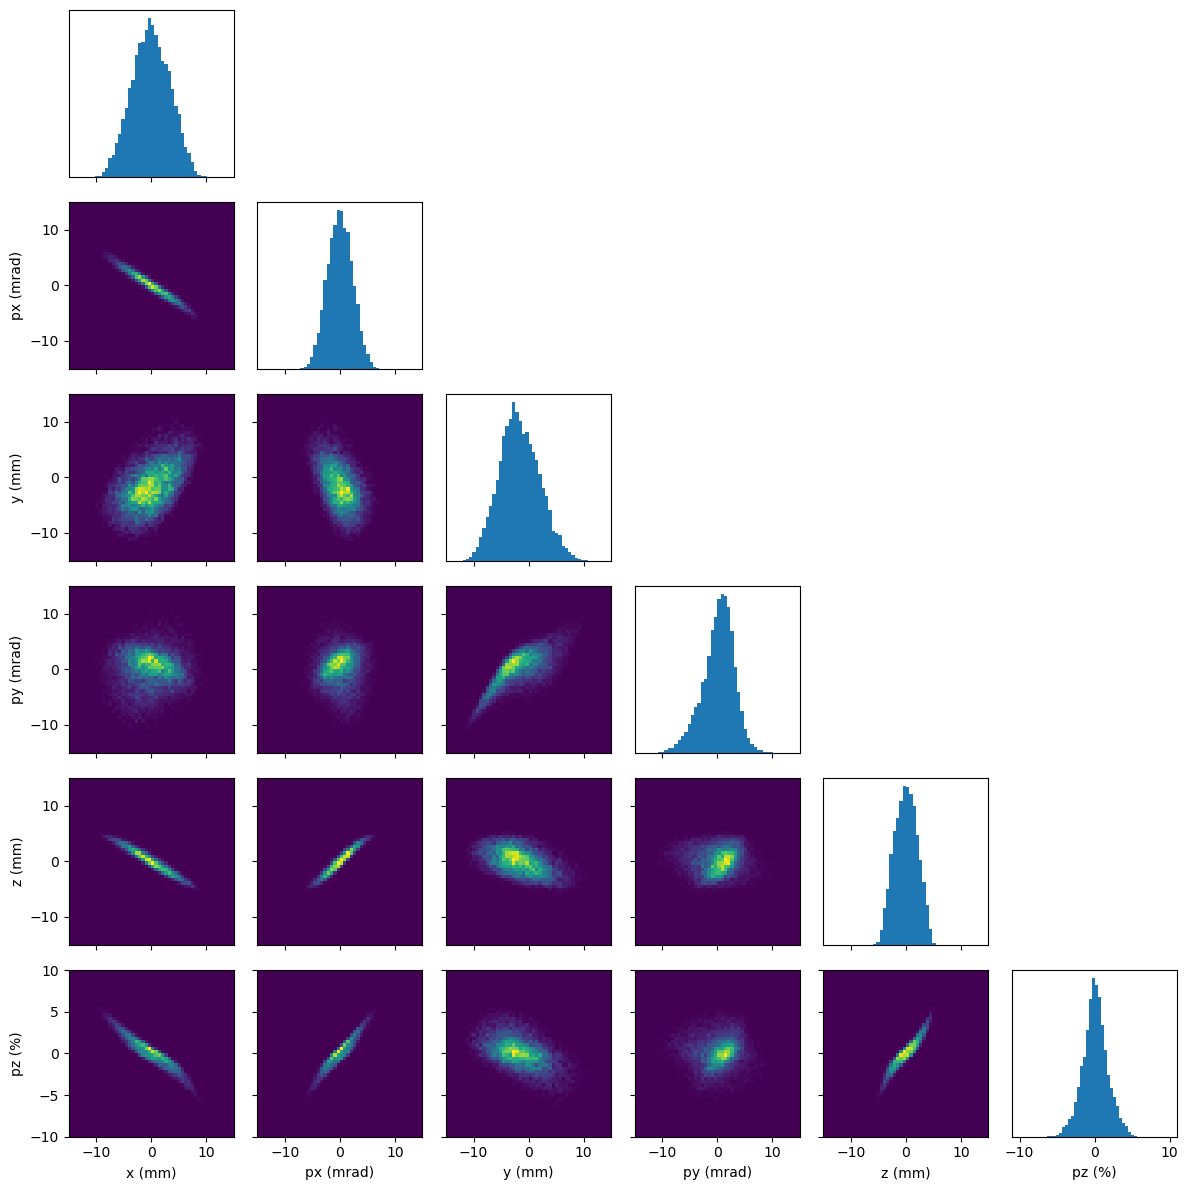

In [16]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam,
                           custom_lims = lims,
                           bins = 50
                           )
plt.show()

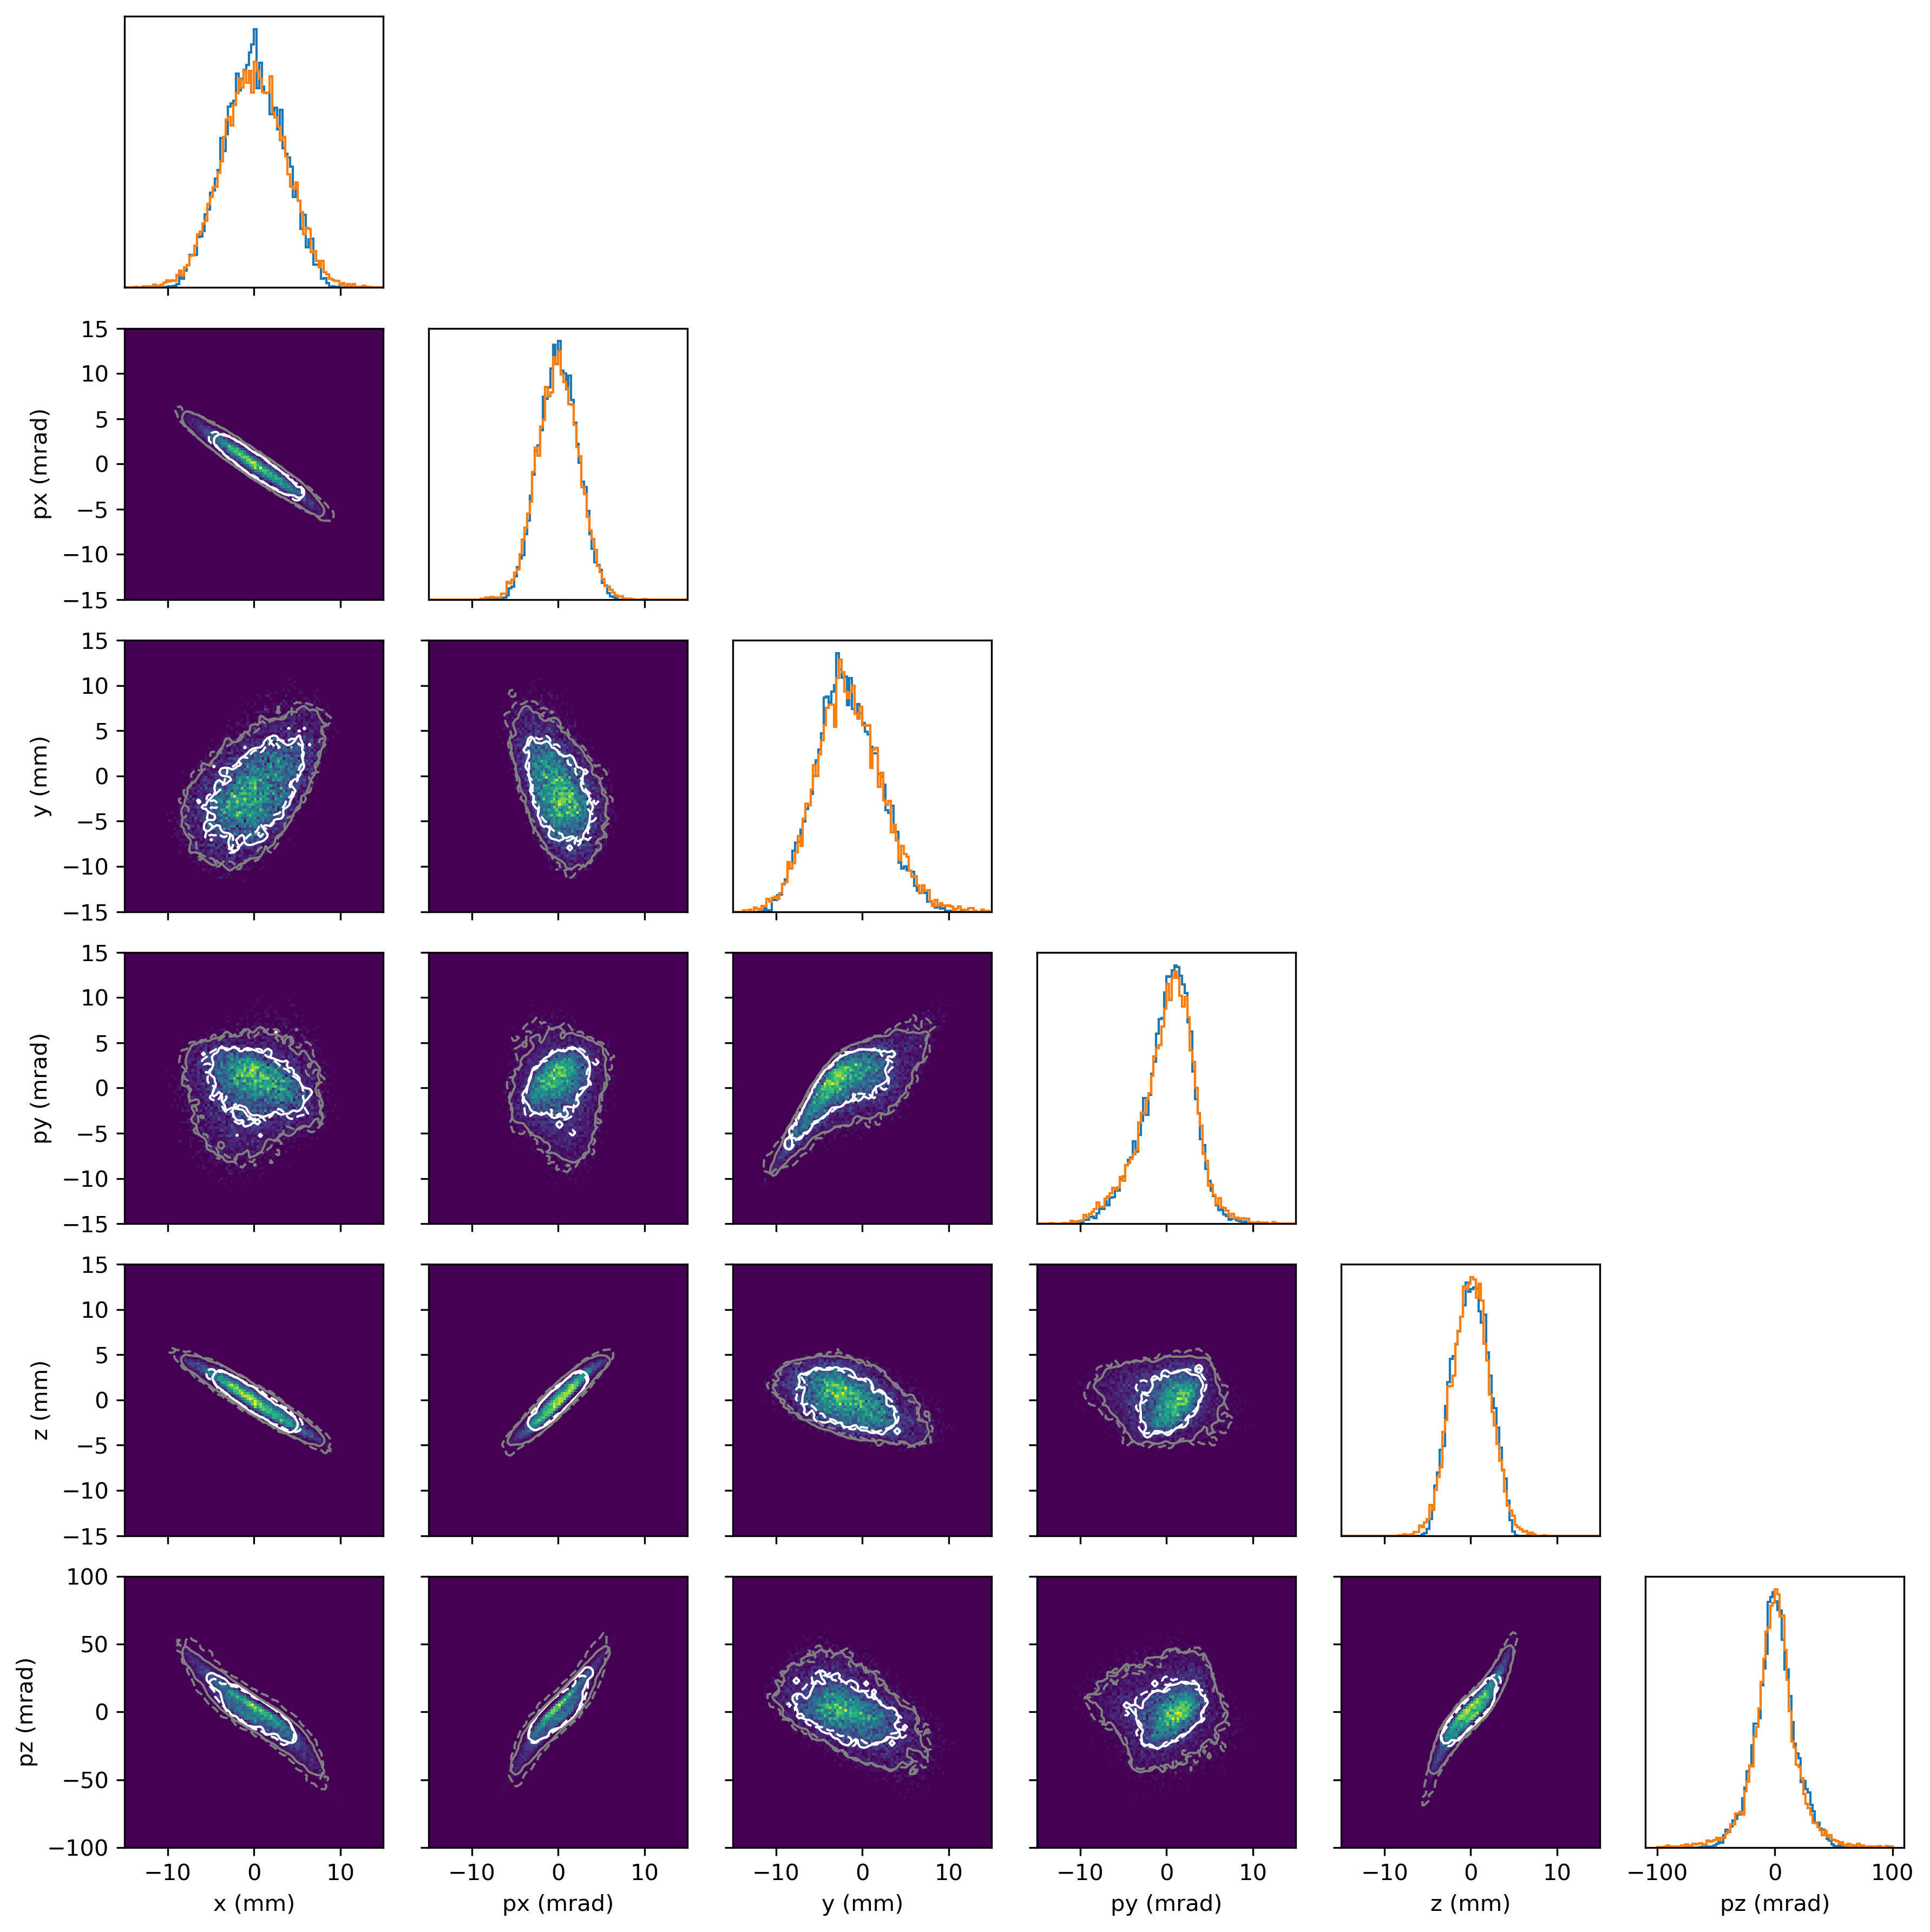

In [17]:
plot_projections_with_contours(pred_beam, gt, custom_lims=lims, bins=100)
plt.show()

In [ ]:
def plot_image_predictions(pred_beam, dset):
    params = dset.params
    imgs_dset = dset.images[:,:,:,select_img,:,:]
    n_k = params.shape[0]
    n_v = params.shape[1]
    n_g = params.shape[2]
    fig, ax = plt.subplots(
        n_v * n_g + 1,
        n_k + 1,
        figsize=( (n_k+1)*2, (n_v*n_g+1)*2 )
    )
    ax[0, 0].set_axis_off()
    ax[0, 0].text(1, 0, '$k_1$ (1/m$^2$)', va='bottom', ha='right')
    for i in range(n_k):
        ax[0, i + 1].set_axis_off()
        ax[0, i + 1].text(
            0.5, 0, f'{params[i, 0, 0, 0]:.1f}', va='bottom', ha='center'
        )
        for j in range(n_g):
            for k in range(n_v):
                ax[2 * j + k + 1, i + 1].imshow(
                    imgs[i, k, j].T, origin='lower', interpolation='none'
                )
                ax[2 * j + k + 1, i + 1].tick_params(
                    bottom=False, left=False,
                    labelbottom=False, labelleft=False
                )

                if k == 0:
                    v_lbl = "off"
                else:
                    v_lbl = "on"
                if j == 0:
                    g_lbl = "off"
                else:
                    g_lbl = "on"

                ax[2 * j + k + 1, 0].set_axis_off()
                ax[2 * j + k + 1, 0].text(
                    1, 0.5, f'T.D.C.: {v_lbl}\n DIPOLE: {g_lbl}',
                    va='center', ha='right'
                )

    return fig, ax